# 사전작업

## PKG_LOAD

### fasttext install guide(by.호재)
- pip install fasttext-wheel
- Microsoft C++ Build Tools 설치 필요
    - https://visualstudio.microsoft.com/ko/visual-cpp-build-tools/
- 결과 값에 대한 ISO 코드 확인은 다음 링크 참조(대부분의 결과는 ISO 639-1)
    - https://ko.wikipedia.org/wiki/ISO_639-1_%EC%BD%94%EB%93%9C_%EB%AA%A9%EB%A1%9D

In [1]:
import pandas as pd
import numpy as np
import fasttext
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, classification_report, make_scorer
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns
import re

detec = fasttext.load_model('lid.176.ftz') # fasttext lenguage detection model
import warnings
warnings.filterwarnings(action='ignore')

## DATA불러오기
- 이 단계에서 사용하는 파일은 사전에 전처리가 되었습니다.
    - OpenRefine, Excel 을 이용한 인코딩, csv 파일 수정
    - CATALOG_DESC 컬럼의 HTML 태그 공백으로 수정

In [2]:
no_product = pd.read_excel('no_product.xlsx')
ab_product = pd.read_excel('ab_product.xlsx')

# 전처리

## BLOCK_STATUS 컬럼 추가

In [3]:
no_product[['BLOCK_STATUS']] = 0
ab_product[['BLOCK_STATUS']] = 1

## 데이터 합치기

In [4]:
all_product = pd.concat([no_product,ab_product])

## 필요한 컬럼만 사용

In [5]:
all_product = all_product[['CATALOG_DESC','BLOCK_STATUS']]

## 공백기준의 단어형태와 escape 사용 제거
- 이 단계에서 숫자 사용은 전처리에서 제외되었으며 숫자제거 전 정확도 0.91, 숫자제거 후 정확도 0.92 로 0.01 정도의 차이를 보입니다.
    - 1. 비정상 이용자의 동일한 whatsapp 번호 사용으로 인한 차이로 추측됩니다. 
    - 2. 100% 등의 표현을 사용한 다수의 데이터가 비정상으로 분류되었기 때문으로 추측됩니다.
    
따라서, 이 데이터에서는 숫자 전처리를 진행하지 않았습니다.

In [6]:
all_product['CATALOG_DESC'] = all_product['CATALOG_DESC'].str.replace(r'[^\w\s]', ' ', regex=True)
all_product['CATALOG_DESC'] = all_product['CATALOG_DESC'].str.replace(r'[(_x000D_\n)]', ' ', regex=True)
# all_product['CATALOG_DESC'] = all_product['CATALOG_DESC'].str.replace(r'[0-9]', ' ', regex=True)
all_product['CATALOG_DESC'] = all_product['CATALOG_DESC'].str.lower()

In [7]:
all_product = all_product.dropna().reset_index(drop=True)

## fasttext language detection model 사용
해당 모델은 완벽하게 language detection 을 수행하지는 못합니다. 여기서 사용되는 데이터를 api로 이용하는 것에 대한 한계점이 존재하기 때문에 대안용으로 사용되었습니다.

- 일부 외래어로 인해 언어 분류가 잘못되는 문제가 발생합니다.
    - Fasttext 의 language detection model 을 활용하여 1차적인 분류를 하였으나, 이 모델은 완벽히 언어를 분류해내지는 못합니다.
    - 이는 ferrero, nutella, nvidia, la roche posay 등의 단어로 인해 it(이탈리아)어, fr(프랑스어)로 인식하기 때문이라 추측됩니다.
- escape 문자가 존재하면 분류를 수행하지 못합니다. 실행 전 escape 문자를 제거해주세요.

In [8]:
all_product['LAN_CHECK'] = np.nan

for i in range(0,len(all_product)):
    result = detec.predict(all_product['CATALOG_DESC'][i], k=1)
    all_product['LAN_CHECK'][i] = result[0][0][9:]

In [9]:
all_product[all_product['LAN_CHECK'] == 'ja'] # 237건
all_product[all_product['LAN_CHECK'] == 'zh'] # 7257건

,CATALOG_DESC,BLOCK_STATUS,LAN_CHECK
76,古家照明吊灯led客厅灯现代简约餐厅灯卧室照明灯豪华曼田星照明包hs6883 蓝色方...,0,zh
152,ferro vanadium 钒铁是由钒和铁组成的铁合金 主要用作炼钢的合...,0,zh
224,我们有2 多种手工缝纫针 其中 自穿针和串珠针非常受欢迎 我公司采用先进的日本镀镍技术 使...,0,zh
225,我们有2 多种手工缝纫针 其中 自穿针和串珠针非常受欢迎 我公司采用先进的日本镀镍技术 使...,0,zh
227,低温市场发展到现在 液氮罐已经不是什么新鲜产品了 能够提供液氮罐的品牌有很多 kgs...,0,zh
...,...,...,...
676855,该药物是一种人类细胞毒性t淋巴细胞抗原4 ctla 4 阻断抗体 通过阻断帮助肿瘤逃避免疫检...,1,zh
676918,适用于1 不可切除或转移性黑色素瘤 opdivo作为单药用于...,1,zh
678842,5 氟 2 硝基苯甲醚5 fluoro 2 nitroanisole448 19 12 甲氧...,1,zh
682113,\tproname bk e bp bk eb p bkebdp ...,1,zh


## 특정언어 제거
- 중국어와 일본어는 공백으로 구분되지 않는 특징을 가지고 있고, 기업과의 협의를 통하여 이런 특정 언어를 제외하고 모델을 만들기로 협의되었습니다.
    - Fasttext 의 language detection model 을 활용하여 1차적인 분류를 하였으나, 이 모델은 완벽히 언어를 분류해내지는 못함
    - 이는 ferrero, nutella, nvidia, la roche posay 등의 단어를 이탈리아어, 프랑스어로 인식하기 때문이라 추측됨
    - 그러므로 zh(중국어), ja(일본어) 로 분류된 데이터만 제외

In [10]:
all_product['LAN_CHECK'] = all_product['LAN_CHECK'].replace('zh',np.nan)
all_product['LAN_CHECK'] = all_product['LAN_CHECK'].replace('ja',np.nan)
all_product = all_product.dropna().reset_index(drop=True)

## 데이터 분리

In [11]:
X = all_product['CATALOG_DESC']
Y = all_product['BLOCK_STATUS']

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=0)

In [13]:
print(x_train.shape)
print(y_train.shape)

(476714,)
(476714,)


## STOPWORD 생성
- 영어 불용어와 관련된 단어모음인 nltk 의 stopwords 를 사용하였습니다.
- 사전에 추출한 정상/비정상 데이터의 CATALOG_DESC 단어 상위 100개의 중복값을 추출하여 duplication 으로 지정하였습니다.
    - duplication 을 stopword 로 지정할 경우 모델의 결과에 영항을 미침
    - 이 경우 duplication 을 stopword로 사용할 경우 정확도가 높아지므로 포함함
    - 링크 주소로 사용되는 http, www, com 을 추가함

In [14]:
import nltk
import string
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
duplication = ['us','delivery','whatsapp','contact','100','order','guaranteed','number','products','shipping','product','free','days','offer','new','original','warranty','quality','get','payment','good','details','used','available','company','working','please','information','brand','factory','best','make','high','made','service','time','price','10','box','packaging','protection','white','customers','http','www','com']

In [16]:
list_stopwords = stopwords.words('english') + duplication

In [17]:
list_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

## CATALOG_DESC vectorizer
- CountVectorizer를 이용하여 token pattern 을 문자열데이터에서 3개 이상이 단어만을 토큰화하였습니다.
    - 이 정규표현식은 숫자와 _ 를 함께 벡터화하는 코드
    - 숫자를 제외할 경우 전체적인 평가값이 떨어지는 경향이 있으므로 숫자를 제외하지 않음

In [18]:
cv = CountVectorizer(ngram_range=(1,4), min_df=5 ,stop_words=list_stopwords, token_pattern=r'[\w]{3,}')
x_train_count = cv.fit_transform(x_train)

In [19]:
x_train_count
cv.vocabulary_

{'oem': 2024991,
 'well': 3310878,
 'oem well': 2028914,
 'margin': 1803554,
 'font': 1208117,
 'helvetica': 1384571,
 'neue': 1991390,
 'min': 1888166,
 'height': 1378261,
 'span': 2810120,
 'color': 677611,
 'dca1': 861566,
 '821': 142735,
 'respirator': 2539704,
 'popular': 2261641,
 'particulate': 2140514,
 'world': 3364222,
 'n95': 1961621,
 'masks': 1812045,
 'disposable': 933120,
 'respirators': 2539900,
 'featuring': 1140299,
 'lightweight': 1682461,
 'construction': 741969,
 'greater': 1321905,
 'worker': 3360776,
 'comfort': 694434,
 'increased': 1479468,
 'wear': 3290161,
 'adjustable': 210657,
 'nose': 2009524,
 'clip': 653136,
 'helps': 1383890,
 'provide': 2383666,
 'custom': 829471,
 'fit': 1180276,
 'secure': 2656275,
 'seal': 2647090,
 'esigned': 1073737,
 'workers': 3360910,
 'protect': 2378420,
 'certain': 578193,
 'non': 2001421,
 'oil': 2035195,
 'based': 390169,
 'particles': 2139602,
 'also': 256000,
 'model': 1907172,
 'smaller': 2777959,
 'faces': 1113608,
 'th

# MODEL - MultinominalNB
- 모델의 파라메터는 마지막에 실행되는 하이퍼 파라메터를 이용하여 최적의 파라메터 값을 사용하였습니다.
    - alpha: 스무딩을 뜻하며 학습 데이터에 없는 새로운 단어나 특성이 테스트 데이터에 나타날 경우, 확률이 0이 되는 것을 방지하기 위해 사용
    - fit_prior: 분류기가 클래스의 사전 확률을 학습할지 여부를 결정

In [20]:
model = MultinomialNB(alpha = 0.0001, fit_prior = True)
model.fit(x_train_count, y_train)

MultinomialNB(alpha=0.0001)

# 모델 검증/평가

In [21]:
x_test_count = cv.transform(x_test)
y_hat = model.predict(x_test_count)

## CONFUSUION MATRIX

In [22]:
# 혼동행렬
cm = confusion_matrix(y_test, y_hat)
cm

array([[126269,  20371],
       [  6227,  51440]], dtype=int64)

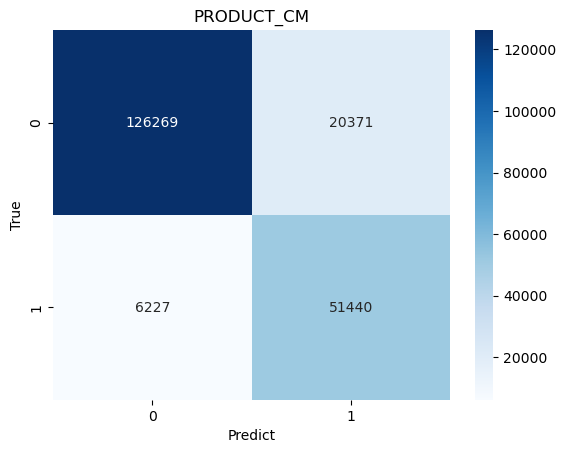

In [23]:
# 혼동행렬 heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g') # fmt = 'g' 를 이용해 정수표현
plt.title('PRODUCT_CM')
plt.xlabel('Predict')
plt.ylabel('True')

plt.show()

## 종합평가

In [24]:
print(f'Accuracy: {accuracy_score(y_test, y_hat):.3f}')
print(f'Precision:{precision_score(y_test, y_hat):.3f}')
print(f'recall:{recall_score(y_test, y_hat):.3f}')
print(f"F1_micro: {f1_score(y_test, y_hat, average='micro'):.3f}")
print(f"F1_macro: {f1_score(y_test, y_hat, average='macro'):.3f}")
print(f"F1_weight: {f1_score(y_test, y_hat, average='weighted'):.3f}")
pred_proba_positive = model.predict_proba(x_test_count)[:,1]
print(f"F1_score: {f1_score(y_test, y_hat):.3f}")
print(f'AUC: {roc_auc_score(y_test, pred_proba_positive):.3f}')

Accuracy: 0.870
Precision:0.716
recall:0.892
F1_micro: 0.870
F1_macro: 0.850
F1_weight: 0.874
F1_score: 0.795
AUC: 0.919


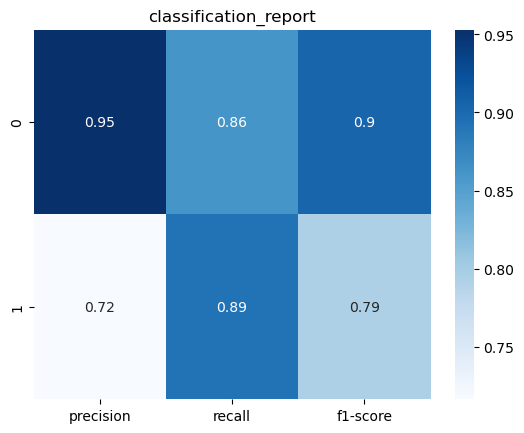

In [31]:
# 계산
cr = classification_report(y_test, y_hat, output_dict='Ture')
report_df = pd.DataFrame(cr).T

# 시각화
sns.heatmap(report_df.iloc[:2,:-1], annot=True, cmap='Blues')
plt.title('classification_report')
plt.show()

## ROC_AUC CURVE

In [25]:
fpr, tpr, threshold = roc_curve(y_test, pred_proba_positive)
roc_auc = auc(fpr, tpr)

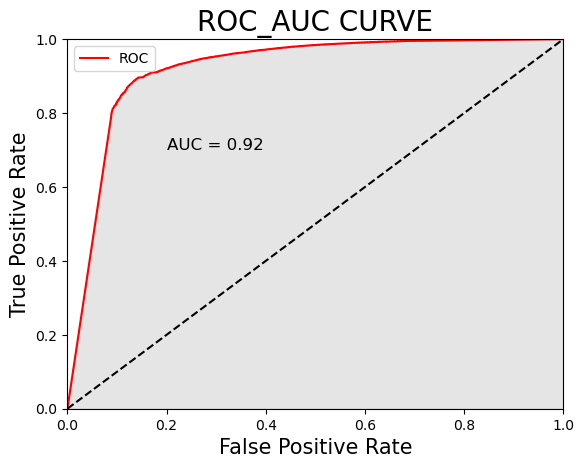

In [26]:
plt.plot(fpr,tpr, color='red', label='ROC')
plt.title('ROC_AUC CURVE', size=20)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc='best')
plt.fill_between(fpr, tpr, 0, alpha=0.2, color='grey')
plt.text(0.2, 0.7, 'AUC = %0.2f' % roc_auc, fontsize=12)
plt.show()

## 평균교차검증

In [28]:
# 주의1! 이 코드를 실행 할 경우 X데이터 전체에 대해 새로운 fit_transform 을 수행하므로 많은 시간이 소요됩니다.
# 주의2! 이 코드를 실행하면 이전의 train,test 로 분리하여 검증, 평가한 값들에 영향을 미치게 됩니다. 그러므로 다시 위에 코드들을 실행할 필요가 있다면 [2.4  CATALOG_DESC vectorizer] 단계부터 다시 실행하세요.

X_count = cv.fit_transform(X)
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(model, X_count, Y, scoring='accuracy', cv=stratified_kfold)
print('교차 검증별 정확도: ', np.round(scores,3))
print('평균 검증 정확도: ', np.round(np.mean(scores),3))

교차 검증별 정확도:  [0.874 0.876 0.874 0.873 0.875]
평균 검증 정확도:  0.874


# 하이퍼파라메터 조합

In [29]:
# 파라메터 정의
hyperparameters = {
    'alpha': np.linspace(0.0001, 1),
    'fit_prior': [True, False]
}

clf = MultinomialNB()

# 그리드서치를 이용한 파라메터 조합 확인
grid_search = GridSearchCV(clf, hyperparameters, cv=5)
grid_search.fit(x_train_count, y_train)

print("Best hyperparameters: ", grid_search.best_params_)

Best hyperparameters:  {'alpha': 0.0001, 'fit_prior': True}
